# Evolution of COVID-19 pandemic

The coronavirus disease is rapidly spreading worldwide and the number of cases in Europe is rising with increasing pace in several affected areas. [European Centre for Disease Prevention and Control](https://www.ecdc.europa.eu/en) is closely monitoring this outbreak providing daily updates of the epidemiological data.

Original data from ECDC (blue points) is supplemented with predictions based on the logistic function model (red curves).

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
show_countries = ['China', 'Sweden', 'Russia']
make_full_report = True

In [4]:
def get_covid19():
    import pandas as pd
    import os
    import json
    import wget
    
    url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/'
    try:
        target = 'covid19.json'
        if os.path.exists(target):
            os.remove(target)
        wget.download(url + 'json', target)
        df = pd.DataFrame(json.load(open(target))['records'])
    except:
        try:
            target = 'covid19.csv'
            if os.path.exists(target):
                os.remove(target)
            wget.download(url + 'csv', target)
            df = pd.read_csv(target)
        except:
            raise Exception('can not get covid19 data')
    
    df['dateRep'] = pd.to_datetime(df.dateRep)
    df['day'] = pd.to_numeric(df.day)
    df['month'] = pd.to_numeric(df.month)
    df['year'] = pd.to_numeric(df.year)
    df['cases'] = pd.to_numeric(df.cases).abs()
    df['deaths'] = pd.to_numeric(df.deaths).abs()
    df['popData2019'] = pd.to_numeric(df.popData2019)
    
    return df

In [5]:
def daily_cases(ax, days, cases):
    ax.set_ylabel('Daily cases, 10$^3$')
    ax.bar(days, cases, width=1.0, alpha=0.5)
    ax.plot(days, cases, '.')
    ax.plot([days[-1]], [cases[-1]], 'o', color='black')
    ax.text(0.05, 0.9, '%.3f' % cases[-1], transform=ax.transAxes)

In [6]:
def total_cases(ax, days, cases):
    totcases = np.cumsum(cases)
    ax.set_ylabel('Total cases, 10$^3$')
    ax.scatter(days, totcases, alpha=0.25)
        
    from scipy.optimize import curve_fit

    # logistic function
    def func(x, a, b, c):
        return a / (1 + np.exp(-b*(x-c)))

    predict = len(days)*2
    currentmax = np.max(totcases)
    if currentmax:
        popt, pcov = curve_fit(func, days, totcases, 
                               bounds=(0, (currentmax*10,1,predict/2)))
        expected = func([predict], *popt)[0]
        ax.plot(range(predict), func(range(predict), *popt), color='red')
        ax.text(predict, expected*0.95, '%.3f' % expected, 
                ha='right', va='top', color='red')

In [7]:
def daily_deaths(ax, days, deaths):
    ax.set_ylabel('Daily deaths, 10$^3$')
    ax.bar(days, deaths, width=1.0, alpha=0.5)
    ax.plot(days, deaths, '.')   
    ax.plot([days[-1]], [deaths[-1]], 'o', color='black')
    ax.text(0.05, 0.9, '%.3f' % deaths[-1], transform=ax.transAxes)

In [8]:
def total_deaths(ax, days, deaths):
    totdeaths = np.cumsum(deaths)
    ax.set_ylabel('Total deaths, 10$^3$')
    ax.scatter(days, totdeaths, alpha=0.25)
        
    from scipy.optimize import curve_fit

    # logistic function
    def func(x, a, b, c):
        return a / (1 + np.exp(-b*(x-c)))

    predict = len(days)*2
    currentmax = np.max(totdeaths)
    if currentmax:
        popt, pcov = curve_fit(func, days, totdeaths, 
                           bounds=(0, (currentmax*10,1,predict/2)))
        expected = func([predict], *popt)[0]
        ax.plot(range(predict), func(range(predict), *popt), color='red')
        ax.text(predict, expected*0.95, '%.3f' % expected, 
                ha='right', va='top', color='red')

In [9]:
def rel_cases(ax, days, cases, deaths, population):
    relcases = cases / (population - deaths) * 100
    totcases = np.cumsum(relcases)
    ax.set_ylabel('Relative cases, %')
    ax.set_yscale('log')
    ax.scatter(days, totcases, alpha=0.25)
    ax.plot(days, totcases)
    ax.plot([days[-1]], [totcases[-1]], 'o', color='black')
    ax.text(0.05, 0.9, '%.3f %%' % totcases[-1], transform=ax.transAxes)

In [10]:
def rel_deaths(ax, days, deaths, cases):
    totdeaths = np.cumsum(deaths)
    totcases = np.cumsum(cases)
    reldeaths = []
    for (x, y) in zip(totdeaths, totcases):
        if y>0:
            reldeaths.append(x/y*100)
        else:
            reldeaths.append(0)
    ax.set_ylabel('Relative deaths, %')
    ax.scatter(days, reldeaths, alpha=0.25)
    
    from scipy.optimize import curve_fit

    # logistic function
    def func(x, a, b, c):
        return a / (1 + np.exp(-b*(x-c)))

    predict = len(days)*2
    currentmax1 = np.max(totdeaths)
    currentmax2 = np.max(totcases)
    if currentmax1:
        popt1, _ = curve_fit(func, days, totdeaths, 
                           bounds=(0, (currentmax1*10,1,predict/2)))
        popt2, _ = curve_fit(func, days, totcases, 
                           bounds=(0, (currentmax2*10,1,predict/2)))
        fitdeaths = func(range(predict), *popt1)
        fitcases = func(range(predict), *popt2)
        fitrelative = fitdeaths / fitcases * 100
        ax.plot(range(predict), fitrelative, color='red')
        expected = fitrelative[-1]
        ax.text(0.05, 0.9, '%.3f %%' % expected, 
                transform=ax.transAxes, color='red')

In [11]:
def mkpage(df, country):
    dc = df[df['countriesAndTerritories'] == country]
    dc = dc[-1:0:-1]
    population = np.float(dc.head(1)['popData2019'])
    date_first = '%d.%02d.%02d' % (dc.head(1)['year'].values[0],
                                   dc.head(1)['month'].values[0],
                                   dc.head(1)['day'].values[0])
    date_last = '%d.%02d.%02d' % (dc.tail(1)['year'].values[0],
                                  dc.tail(1)['month'].values[0],
                                  dc.tail(1)['day'].values[0])
    cases = np.array(dc['cases'].values/1e3)
    deaths = np.array(dc['deaths'].values/1e3)
    days = range(len(cases))
    if len(days) < 10 or np.sum(cases) < 0.100:
        raise Exception('insufficient data for %s' % country)
    
    fig = plt.figure(figsize=(8,10))
    fig.subplots_adjust()
    mln = int(population/1e6)
    ths = int(population/1e3)
    if mln:
        popsize = '%d mln' % mln
    else:
        popsize = '%d ths' % ths
    dates = date_first + ' - ' + date_last
    title = country.replace('_', ' ') + '  (%s),  %s' % (popsize, dates)
    fig.suptitle(title, weight='bold')
    
    ax = fig.add_subplot(321)
    daily_cases(ax, days, cases)
      
    ax = fig.add_subplot(322)
    total_cases(ax, days, cases)
    
    ax = fig.add_subplot(323)
    daily_deaths(ax, days, deaths)
      
    ax = fig.add_subplot(324)
    total_deaths(ax, days, deaths)

    ax = fig.add_subplot(325)
    rel_cases(ax, days, cases, deaths, population/1e3)

    ax = fig.add_subplot(326)
    rel_deaths(ax, days, deaths, cases)

    plt.tight_layout(pad=3)
    return fig

In [12]:
def exponent_monitor(df):
    fig = plt.figure(figsize=(8,12))
    date_last = '%d.%02d.%02d' % (df.head(1)['year'].values[0],
                                  df.head(1)['month'].values[0],
                                  df.head(1)['day'].values[0])
    plt.title('COVID-19 cases, %s' % date_last)
    plt.ylabel('Daily cases')
    plt.xlabel('Total cases')
    plt.yscale('symlog')
    plt.xscale('symlog')
    plt.xlim(100, 10e6)
    plt.ylim(5, 1e5)

    import matplotlib.patheffects as path_effects
    for country in sorted(list(set(df['countriesAndTerritories']))):
        dc = df[df['countriesAndTerritories'] == country]
        dc = dc[-1:0:-1]
        cases = np.array(dc['cases'].values)
        if len(cases) > 7:
            avgcases = dc['cases'].rolling(7).sum()/7
            totcases = np.cumsum(cases)
            name = '  %s' % dc['countryterritoryCode'].values[0]
            if len(name.strip()) == 0:
                name = '  %s' % dc['geoId'].values[0]
            x = totcases[-1]
            y = avgcases.tail(1).values[0]
            if x > 10e3:
                plt.plot(totcases, avgcases, label=name)
                plt.scatter([x], [y], color='red')
                plt.text(x, y, name, path_effects=[path_effects.Stroke(linewidth=3, foreground='white'),
                       path_effects.Normal()])
    #plt.legend(loc='upper left')
    
    return fig

Get COVID-19 data from ECDC.

In [13]:
df = get_covid19()

Check development of the outbreak per countries. Linear characteristic corresponds to the exponential phase of the growth.

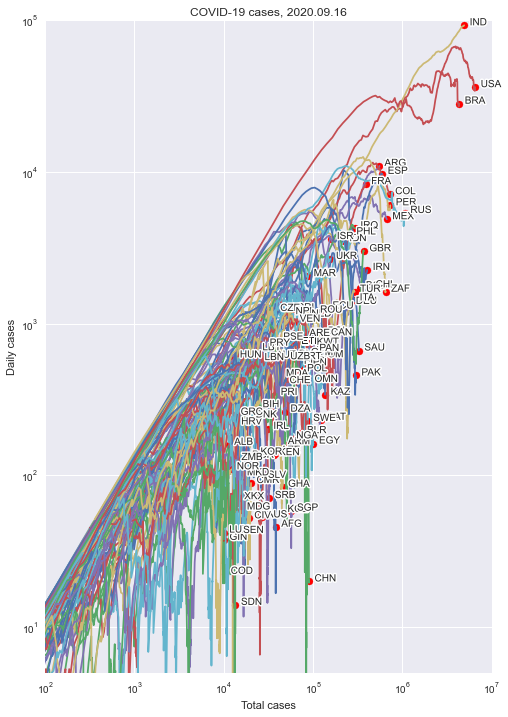

In [14]:
exponent_monitor(df);

Show data for selected countries.

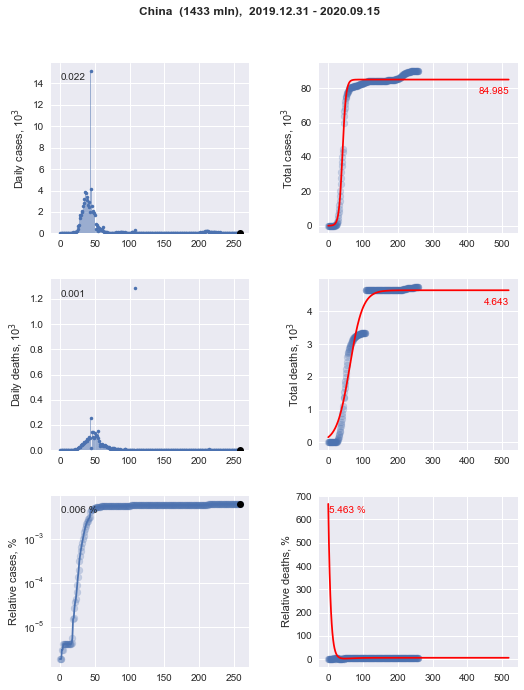

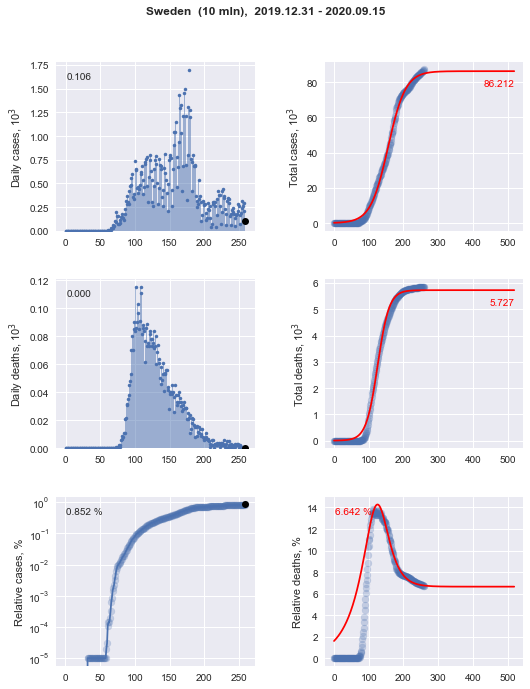

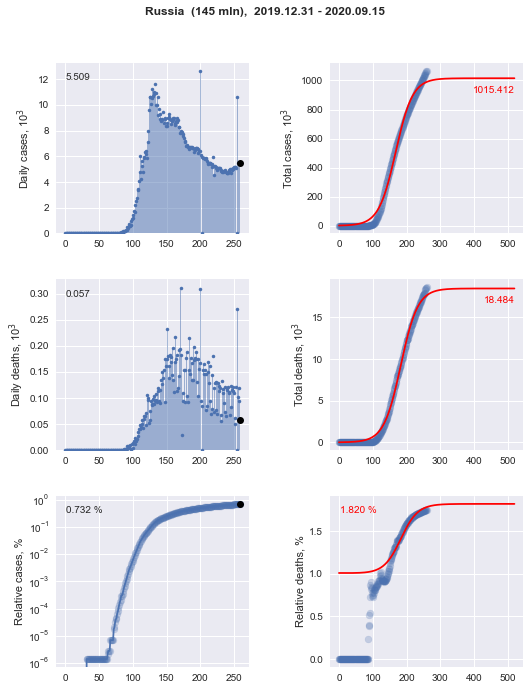

In [15]:
for country in show_countries:
    try:
        mkpage(df, country)
    except:
        print('skipping %s, insufficient data ...' % country)

Make printable report.

In [16]:
if make_full_report:
    countries = sorted(set(df['countriesAndTerritories']))
else:
    countries = show_countries
    
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('covid19.pdf') as pdf:
    fig = exponent_monitor(df)
    pdf.savefig(fig)
    plt.close(fig)
    for country in countries:
        try:
            fig = mkpage(df, country)
            pdf.savefig(fig)
            plt.close(fig)
        except:
            pass

<Figure size 576x720 with 0 Axes>

Figures are saved to file `covid19.pdf`.